In [1]:
%cd ~/research

import gc
import os
import sys
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import yaml
from scipy import signal

sys.path.append("src")
from utility.activity_loader import get_data_dirs, load_individuals
from utility.video import Capture, Writer, concat_field_with_frame
from visualize.individual import write_field as ind_write_field
from visualize.keypoint import write_frame as kps_write_frame

/raid6/home/yokoyama/research


/home/yokoyama/research/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in

In [3]:
room_num = "08"
surgery_num = "001"

In [4]:
cfg_path = "config/individual.yaml"
with open(cfg_path, "r") as f:
    cfg = yaml.safe_load(f)

In [5]:
field = cv2.imread("image/field.png")

In [6]:
data_dirs = get_data_dirs(room_num, surgery_num)
print(data_dirs)

['data/08/001/01', 'data/08/001/02', 'data/08/001/03', 'data/08/001/04', 'data/08/001/05', 'data/08/001/06', 'data/08/001/07', 'data/08/001/08', 'data/08/001/09', 'data/08/001/10', 'data/08/001/11', 'data/08/001/12', 'data/08/001/13', 'data/08/001/14', 'data/08/001/15', 'data/08/001/16', 'data/08/001/17']


In [7]:
individuals = []
for data_dir in tqdm(data_dirs[10:11]):
    json_path = os.path.join(data_dir, ".json", "individual.json")
    loaded = load_individuals(json_path, cfg)
    individuals += list(loaded.values())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.76s/it]


(array([12.,  3.,  5.,  4.,  3.,  1.,  1.,  6.,  2.,  1.,  0.,  0.,  0.,
         0.,  1.,  1.,  1.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  927. ,  1457.4,  1987.8,  2518.2,  3048.6,  3579. ,  4109.4,
         4639.8,  5170.2,  5700.6,  6231. ,  6761.4,  7291.8,  7822.2,
         8352.6,  8883. ,  9413.4,  9943.8, 10474.2, 11004.6, 11535. ,
        12065.4, 12595.8, 13126.2, 13656.6, 14187. , 14717.4, 15247.8,
        15778.2, 16308.6, 16839. , 17369.4, 17899.8, 18430.2, 18960.6,
        19491. , 20021.4, 20551.8, 21082.2, 21612.6, 22143. , 22673.4,
        

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


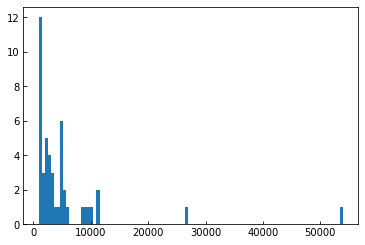

In [8]:
# histogram of length
plt.hist(
    [
        len(ind.get_indicator_all("position"))
        for ind in individuals
        if len(ind.get_indicator_all("position")) > 900
    ],
    bins=100,
)

In [47]:
def calc_movements(individuals, th_length=900, move_size=4800):
    movements = {}
    positions = {}
    for ind in tqdm(individuals):
        pos_dict = ind.get_indicator_all("position")

        if len(pos_dict) <= th_length:
            continue
            
        move = []
        pos = []
        pre_frame_num = list(pos_dict.keys())[0]
        for frame_num in pos_dict.keys():
            if frame_num - pre_frame_num >= 2:
                # zero padding
                for i in range(pre_frame_num + 1, frame_num):
                    move.append(0)
                    pos.append(pos_dict[frame_num])

            # append diff
            pre_pos = np.array(pos_dict[pre_frame_num])
            crr_pos = np.array(pos_dict[frame_num])
            diff = np.linalg.norm(crr_pos - pre_pos)
            move.append(diff)
            pos.append(pos_dict[frame_num])
            
            pre_frame_num = frame_num

        movements[ind.id] = move
        positions[ind.id] = pos
    
    # crop movenemts for move_size
    ret_movements = {}
    ret_positions = {}
    for pid, move_raw in movements.items():
        count = 1
        for i in range(len(move_raw))[::move_size]:
            crop_move = move_raw[i:i + move_size]
            crop_pos = positions[pid][i:i + move_size]
            
            if len(crop_move) < move_size:
                # zero padding
                crop_move += np.zeros(move_size - len(crop_move)).tolist()
                crop_pos += [crop_pos[-1] for _ in range(move_size - len(crop_move))]
        
            ret_movements[f"{pid}_{count:03d}"] = crop_move
            ret_positions[f"{pid}_{count:03d}"] = crop_pos
            count += 1
        
    return ret_movements, ret_positions
    
movements, positions = calc_movements(individuals)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:01<00:00, 255.31it/s]


In [48]:
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.clustering import TimeSeriesKMeans

In [49]:
data = TimeSeriesScalerMinMax().fit_transform(list(movements.values()))

km_euclidean = TimeSeriesKMeans(n_clusters=2, metric="euclidean")
labels = km_euclidean.fit_predict(data)

In [50]:
labels0 = np.array(list(movements.keys()))[np.where(labels==0)[0]]
labels1 = np.array(list(movements.keys()))[np.where(labels==1)[0]]

In [51]:
def plot_movements(movements, labels):
    for i, (label, move) in enumerate(movements.items()):
        if label in labels:
            print(label)
            plt.figure(figsize=(20, 2))
            plt.plot(move)
            plt.ylim((-0.05, 100))
            plt.show()

4435_002


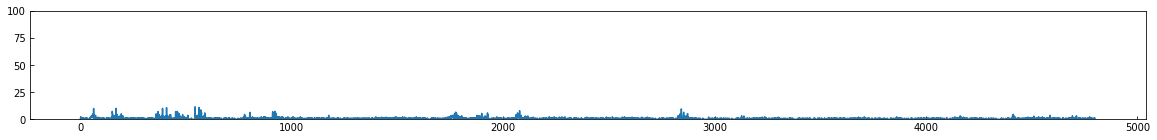

4435_004


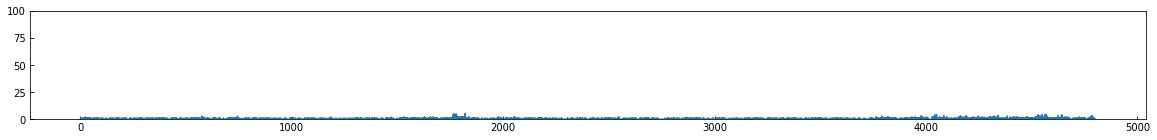

4435_009


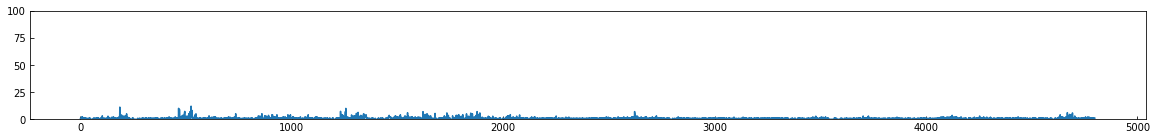

4435_010


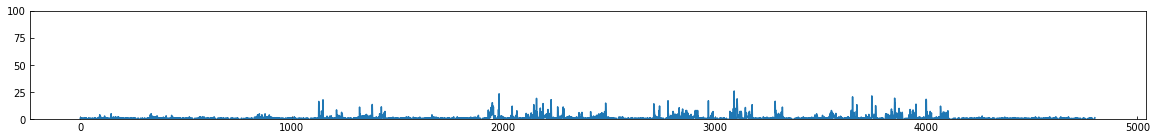

4904_001


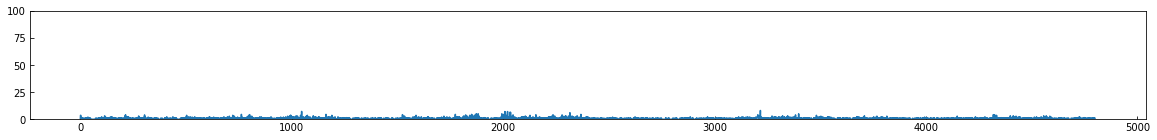

4924_001


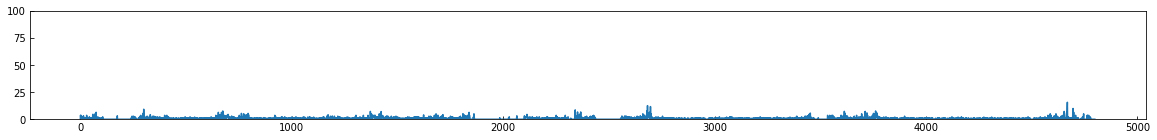

4992_001


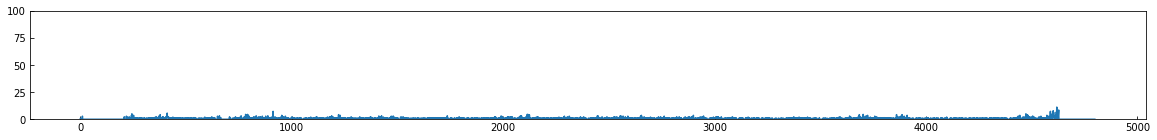

5005_001


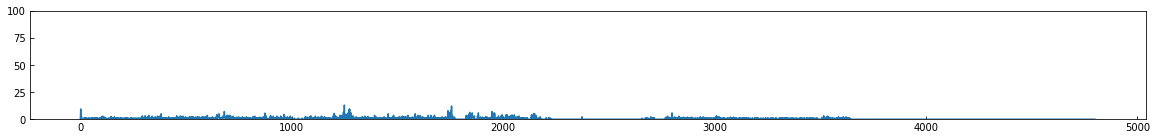

5020_002


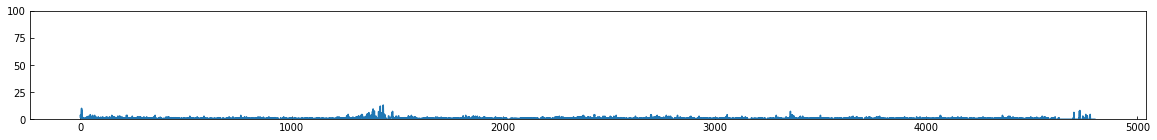

5020_005


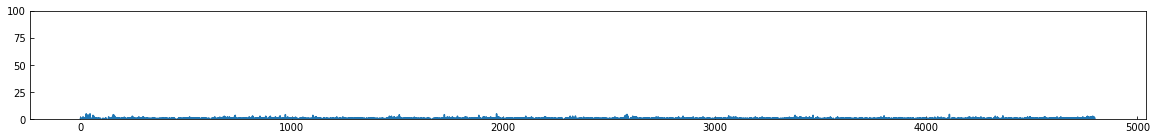

5020_006


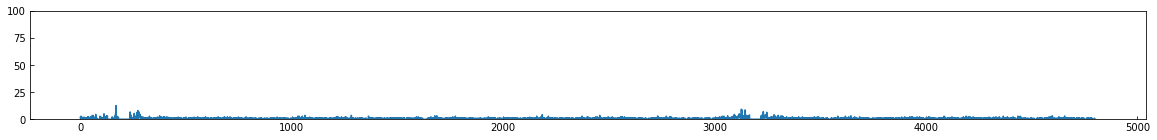

5027_002


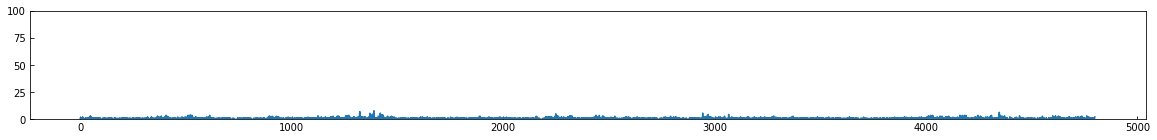

5034_002


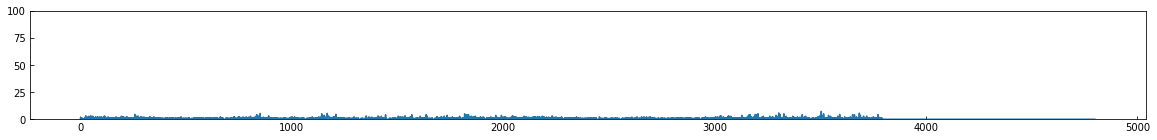

5172_001


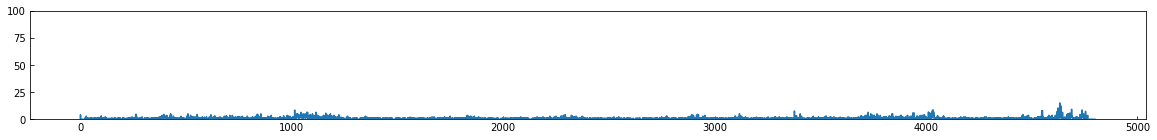

5175_001


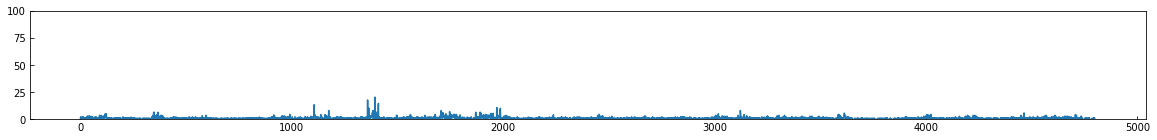

5175_002


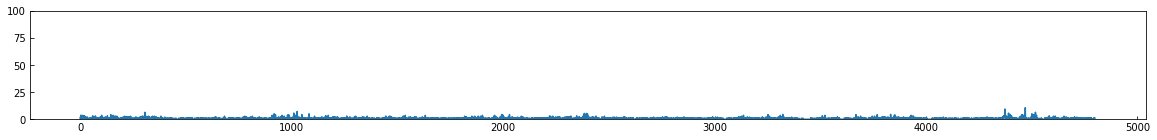

5236_001


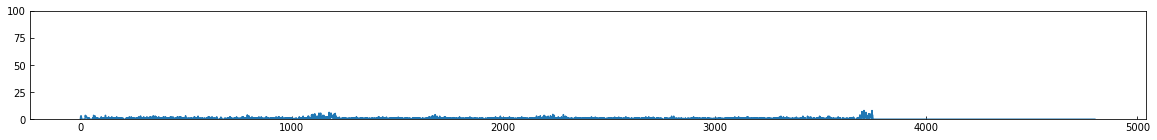

5251_001


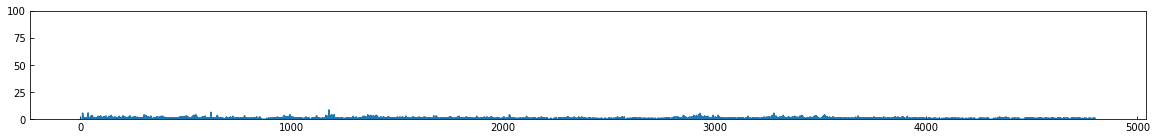

5251_002


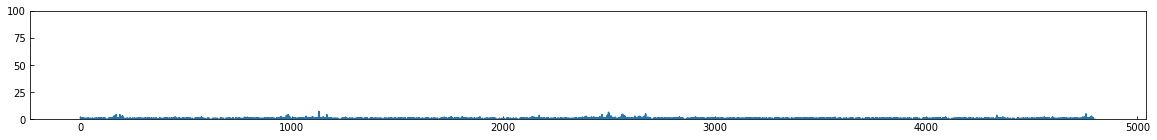

5307_001


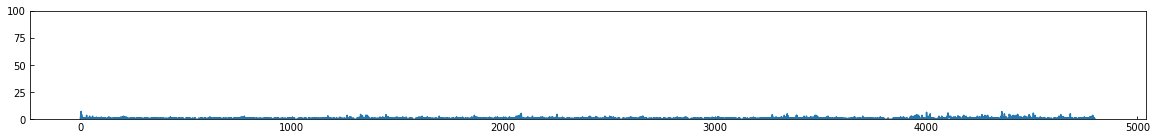

In [52]:
plot_movements(movements, labels0)

4435_001


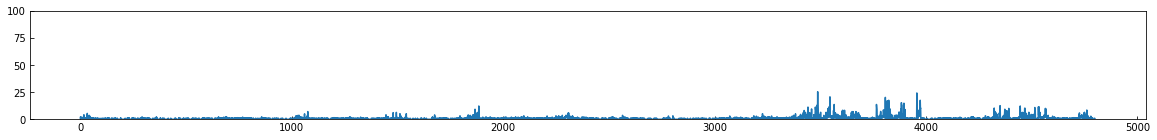

4435_003


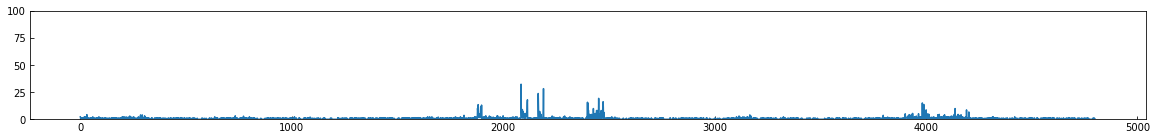

4435_005


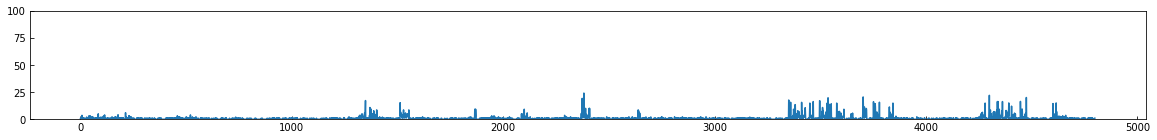

4435_006


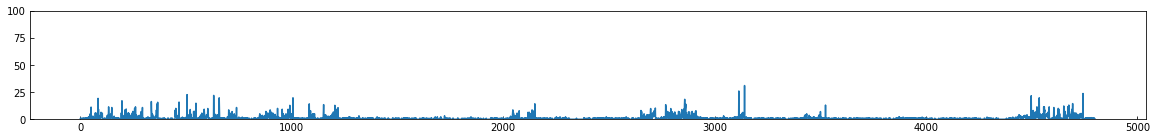

4435_007


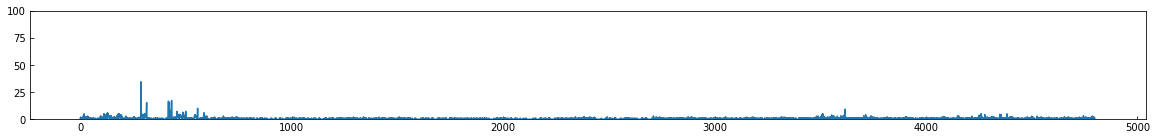

4435_008


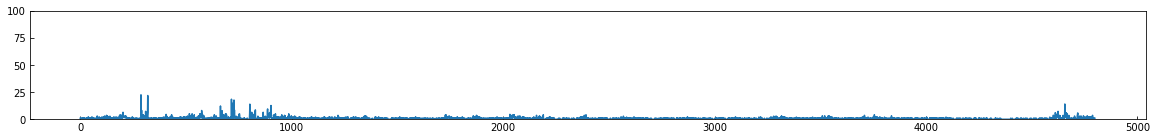

4435_011


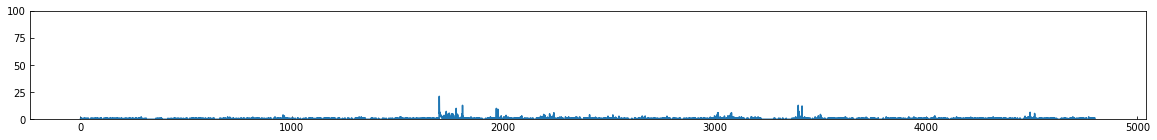

4435_012


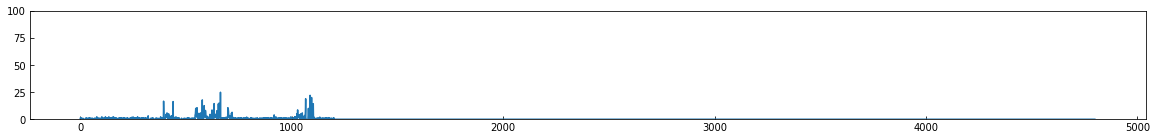

4904_002


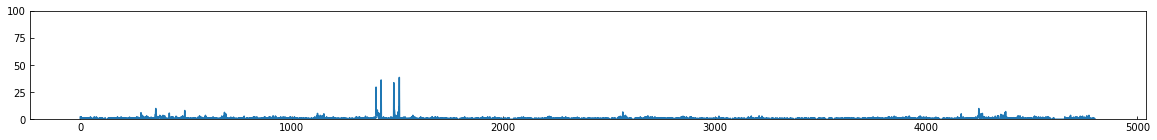

4904_003


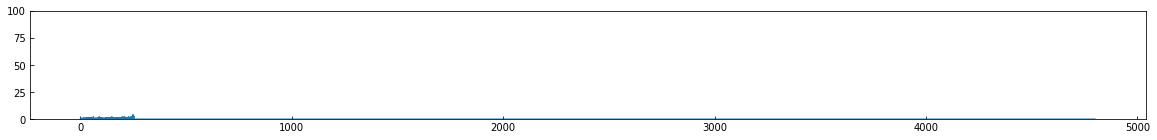

4810_001


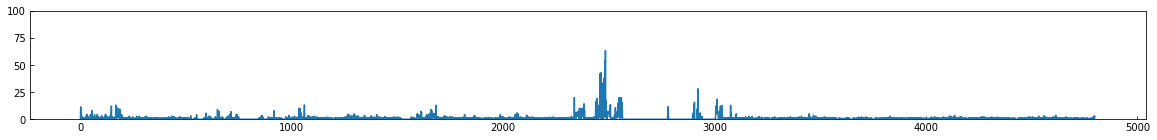

4810_002


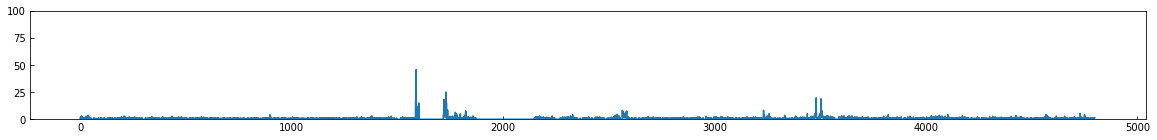

4810_003


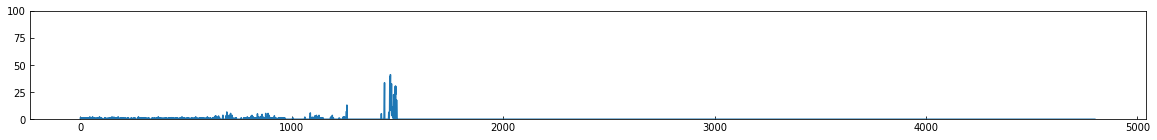

4917_001


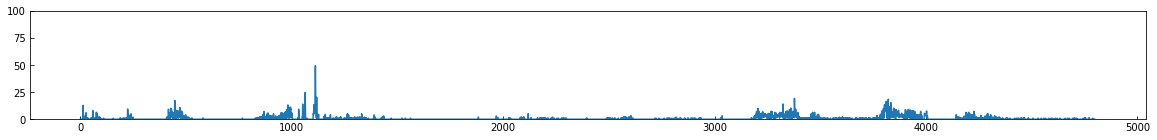

4917_002


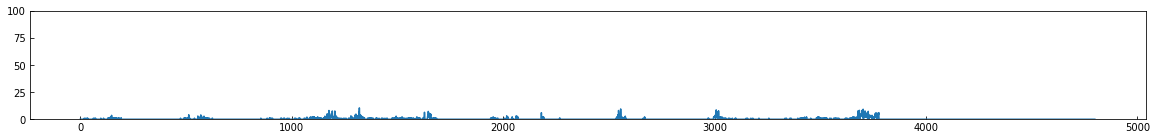

4924_002


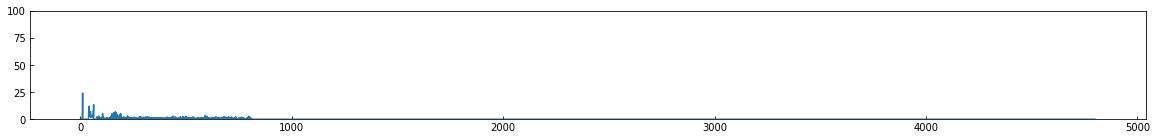

4967_001


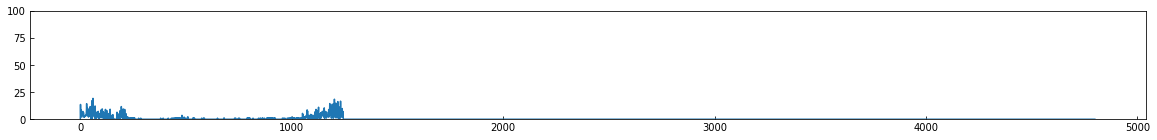

4979_001


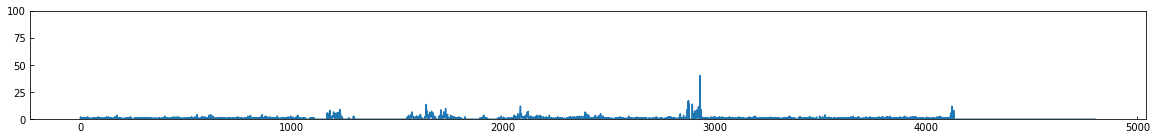

5020_001


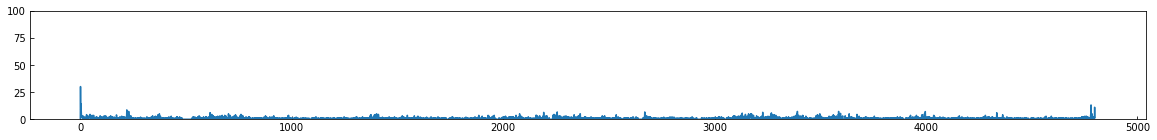

5020_003


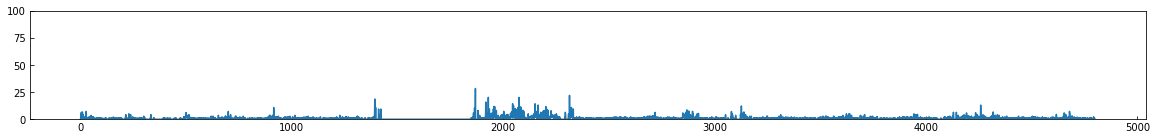

5020_004


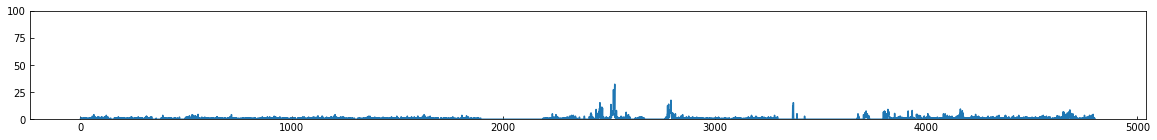

5020_007


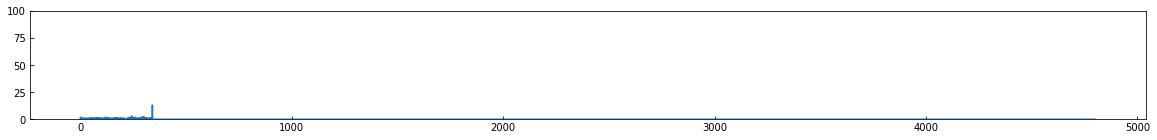

5027_001


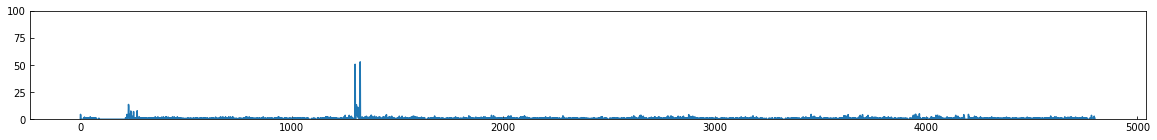

5027_003


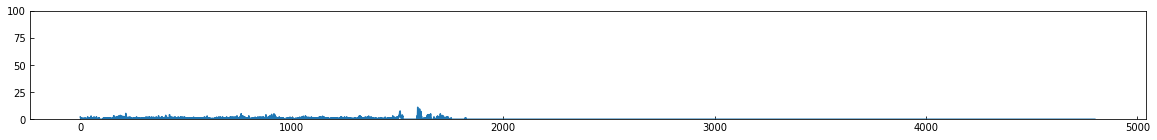

5034_001


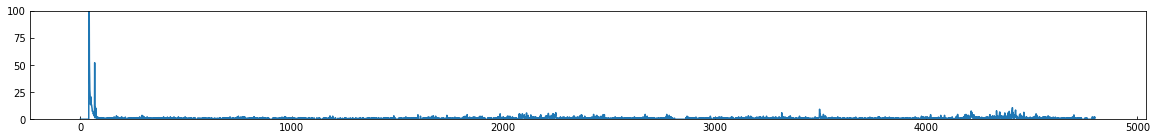

5087_001


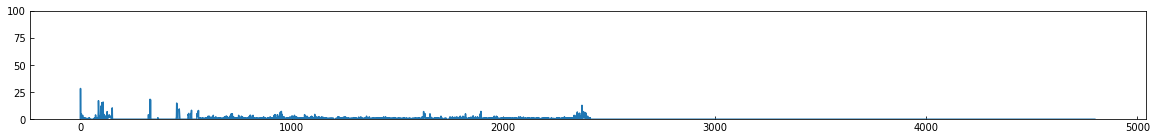

5093_001


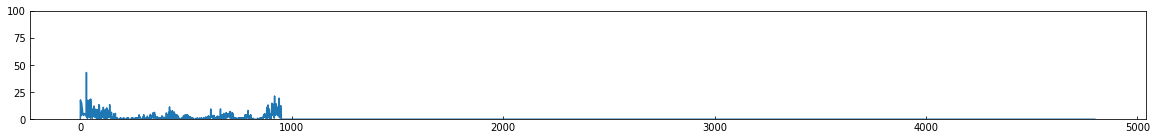

5106_001


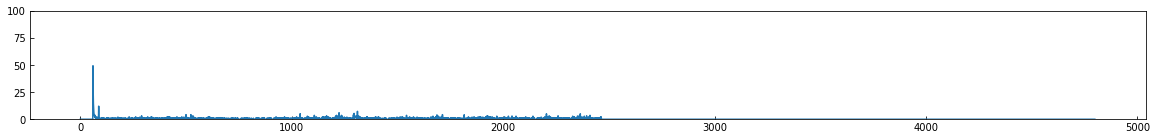

5108_001


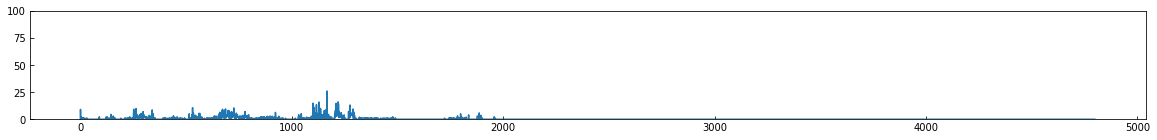

5119_001


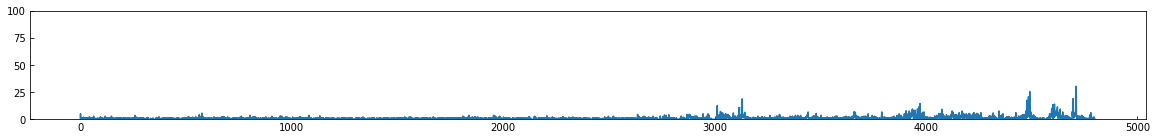

5119_002


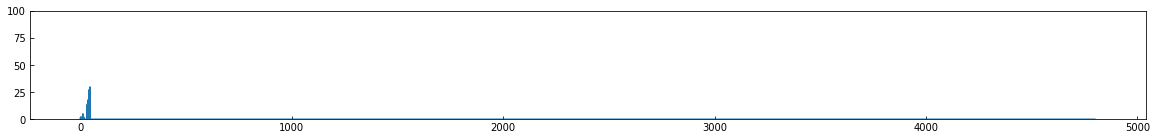

5127_001


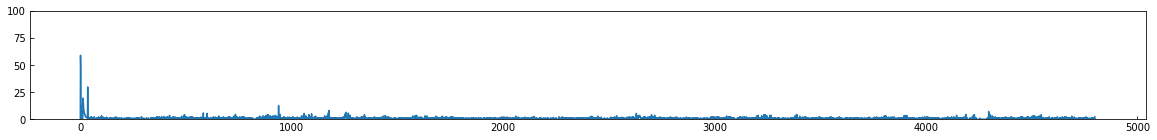

5127_002


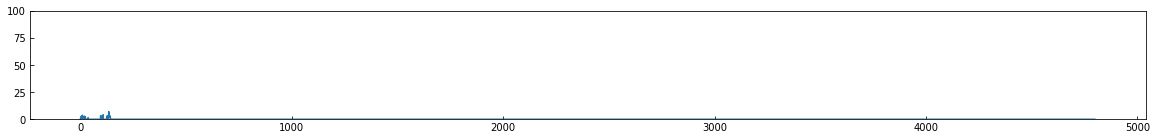

5130_001


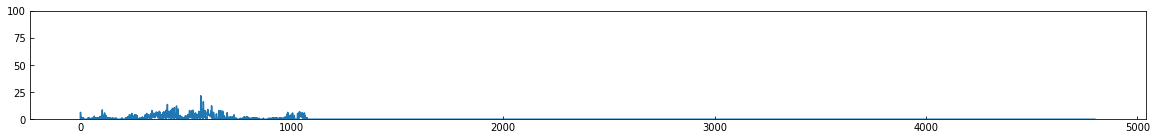

5147_001


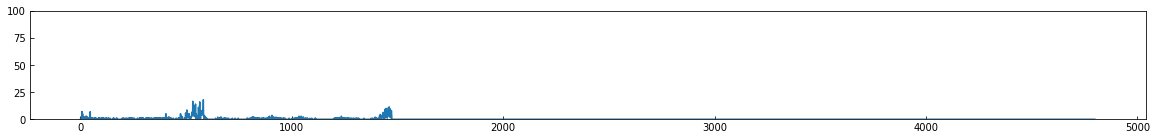

5152_001


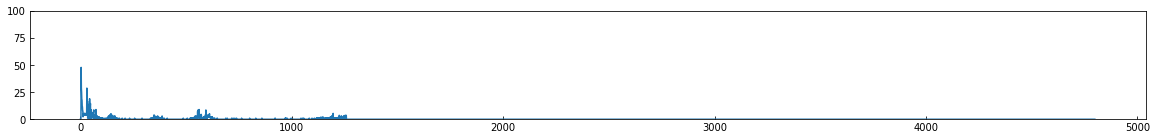

5156_001


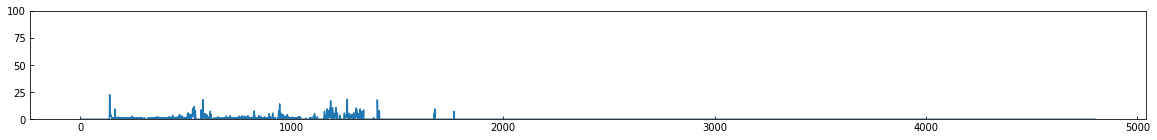

5166_001


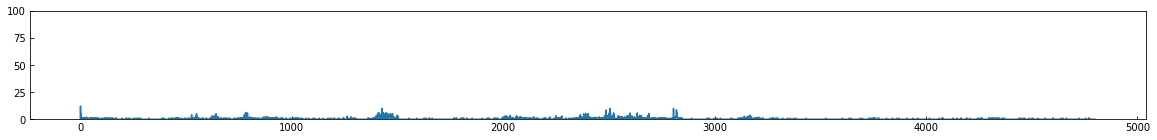

5166_002


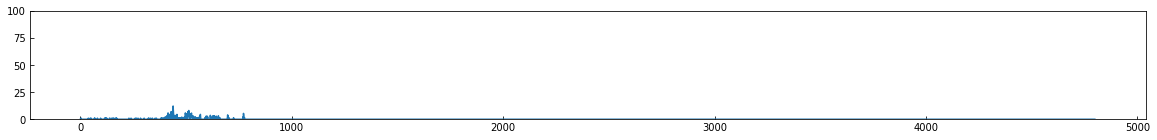

5172_002


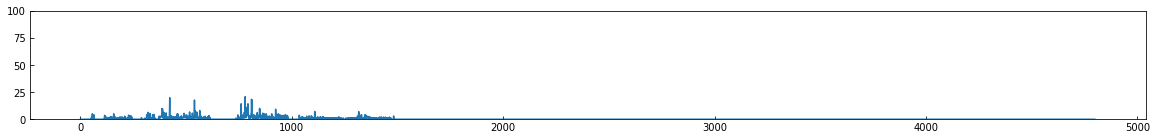

5175_003


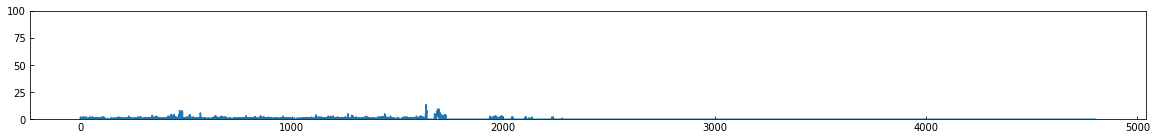

5183_001


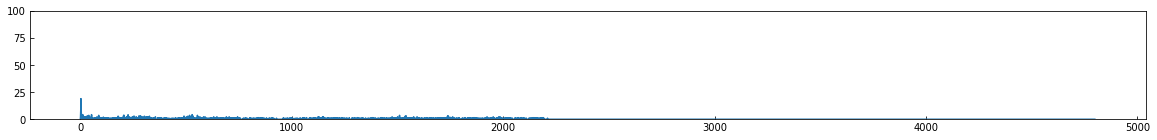

5194_001


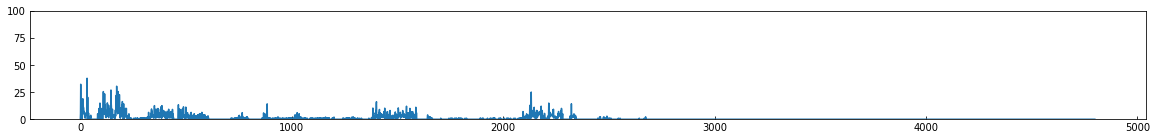

5204_001


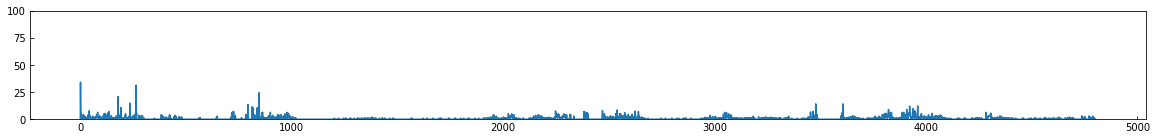

5204_002


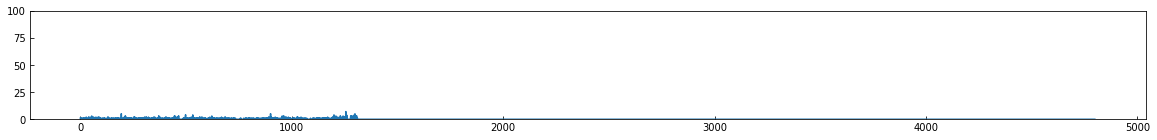

5205_001


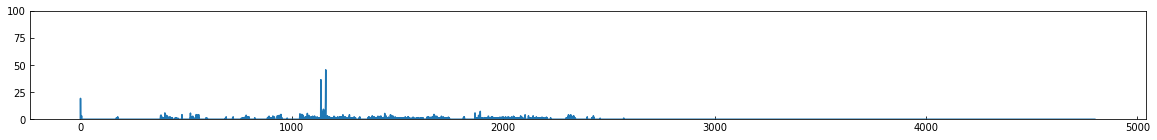

5211_001


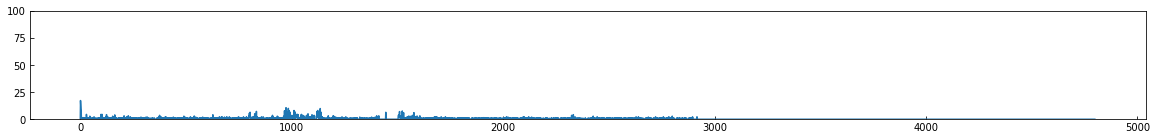

5225_001


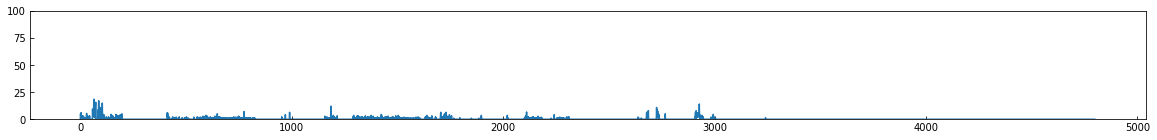

5229_001


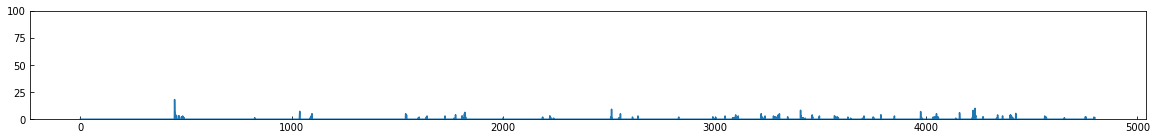

5229_002


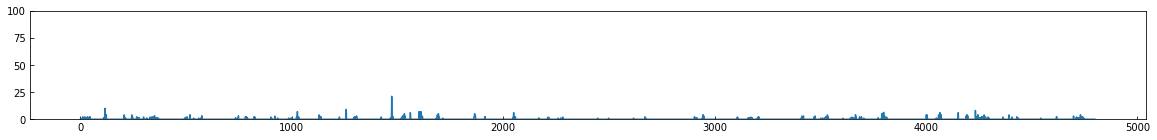

5229_003


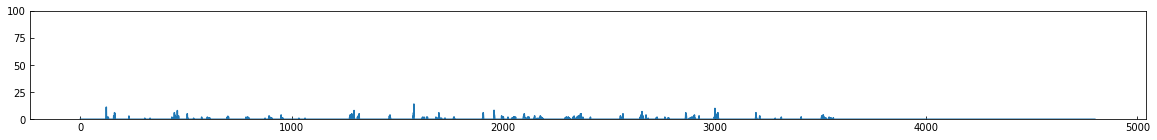

5234_001


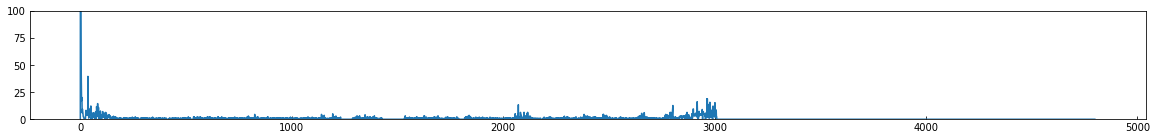

5243_001


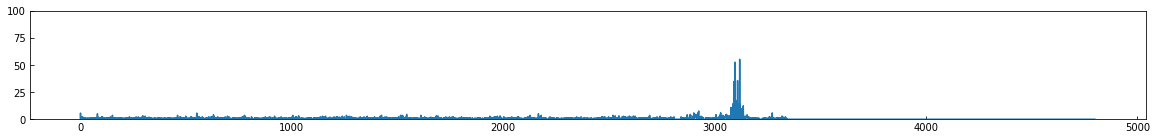

5251_003


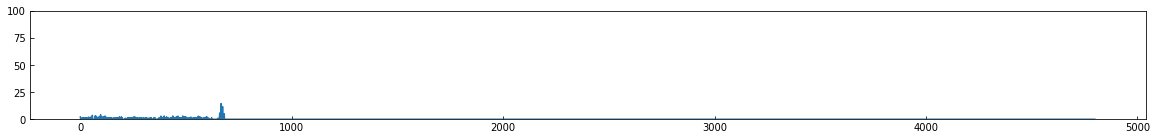

5253_001


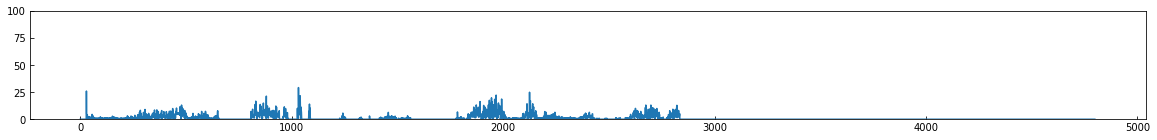

5261_001


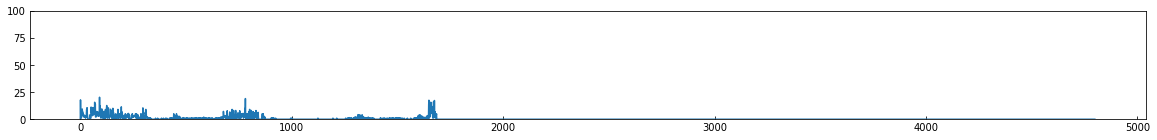

5277_001


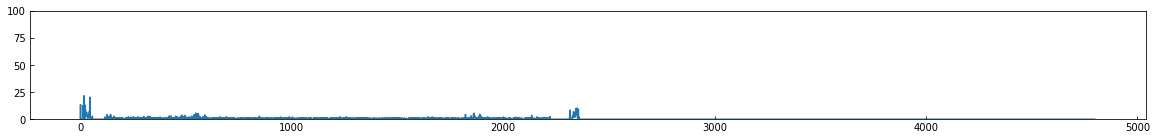

5284_001


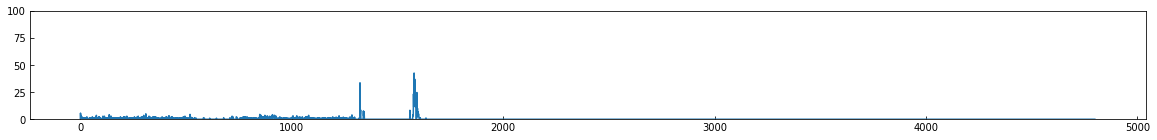

5286_001


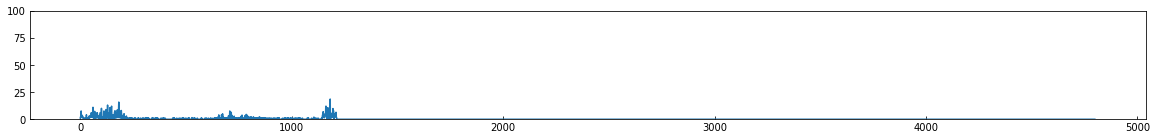

5298_001


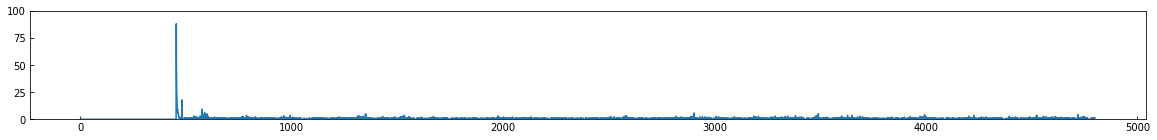

5298_002


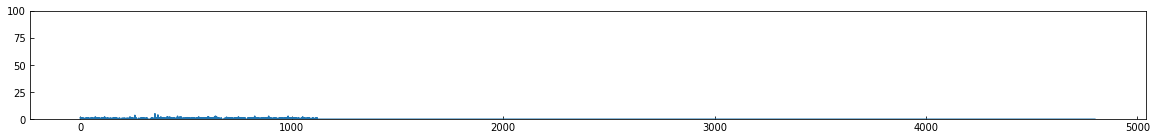

5299_001


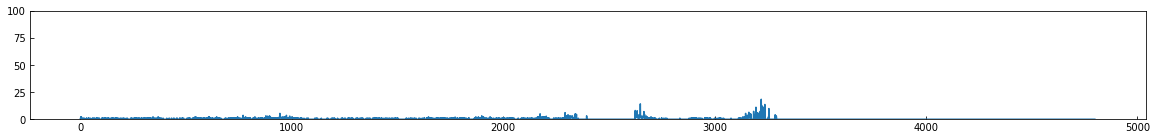

5307_002


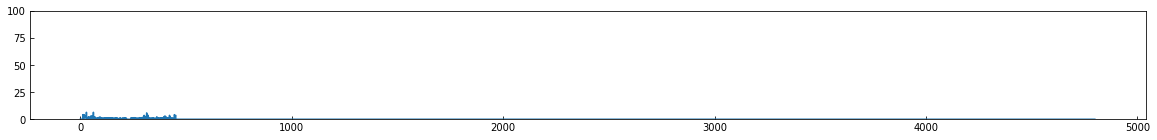

5323_001


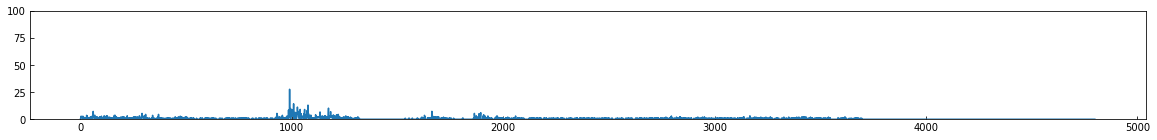

5335_001


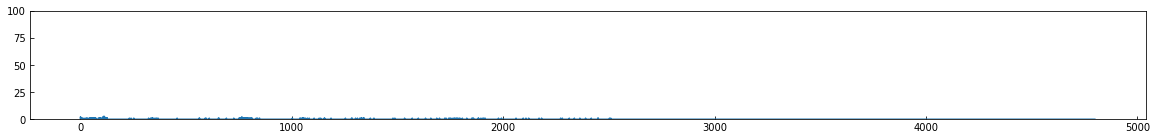

In [53]:
plot_movements(movements, labels1)

In [54]:
def plot_pos(positions, labels):
    plt.figure(figsize=(8, 8))
    for label, pos in positions.items():
        if label in labels:
            pos = np.array(pos).T
            plt.scatter(pos[0], pos[1], label=label)

    plt.axis("off")
    plt.imshow(field)
    plt.axis([0, field.shape[1], field.shape[0], 0])
    # plt.legend()
    plt.show()

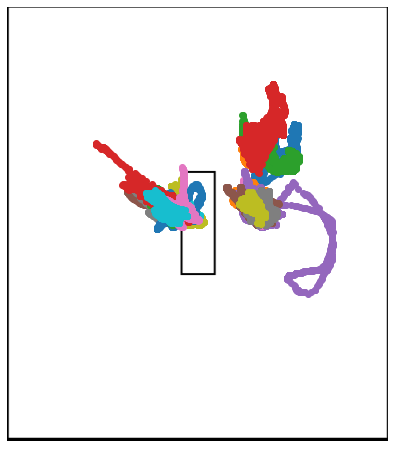

In [55]:
plot_pos(positions, labels0)

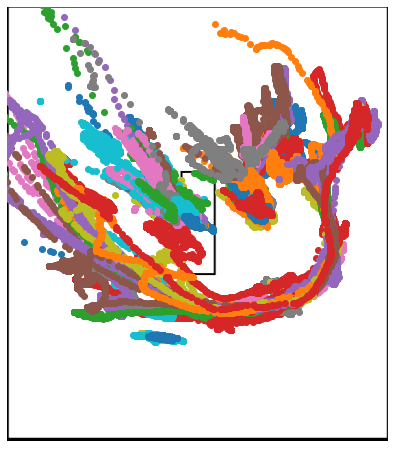

In [56]:
plot_pos(positions, labels1)